# Comparison of ODE solvers for Keplerian mechanics 

In [1]:
using Plots
using Statistics
using BenchmarkTools

using StaticArrays
using LinearAlgebra
using DifferentialEquations

include("kepler.jl") # μ, M2f, f2M, rv_to_coe, coe_to_rv, kepler_solver

function first_order_newton_ode(du, u, p, t)
    factor = - μ / (u[1]^2+u[2]^2+u[3]^2)^(3/2)
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    du[4] = u[1] * factor
    du[5] = u[2] * factor
    du[6] = u[3] * factor
end

function second_order_newton_ode(ddu, du, u, p, t)
    factor = - μ / norm(u)^3
    ddu[1] = u[1] * factor
    ddu[2] = u[2] * factor
    ddu[3] = u[3] * factor
end

pos(rv::AbstractVector{<:Real}) = rv[1:3]
pos(u::ArrayPartition{<:Real}) = u.x[2]
pos(sol::ODESolution) = pos(sol[end])

vel(rv::AbstractVector{<:Real}) = rv[4:6]
vel(u::ArrayPartition{<:Real}) = u.x[1]
vel(sol::ODESolution) = vel(sol[end])

energy(rv::AbstractVector{<:Real}) = rv[4:6]'rv[4:6]/2 - μ/norm(rv[1:3])
energy(u::ArrayPartition{<:Real}) = u.x[1]'u.x[1]/2 - μ/norm(u.x[2])

energy (generic function with 2 methods)

In [2]:
function random_sample(range::UnitRange{T}, n::Integer; allow_less=false) where T <: Integer
    if allow_less
        n = min(n, length(range))
    else
        n <= length(range) || error("The range $range is too short to sample $n elements.")
    end
    sample = Set{T}()
    while length(sample) < n
        union!(sample, rand(range, n - length(sample)))
    end
    sort(collect(sample))
end

function pos_nodal_error(sol::DiffEqBase.AbstractODESolution, real_sol, tspan; samples=1000)
    (t1, t2) = tspan
    range = findfirst(t -> t >= t1, sol.t) : findlast(t -> t <= t2, sol.t)
    times = sol.t[random_sample(range, samples; allow_less=true)]
    times, Float64.( norm.( pos.(sol.(times)) .- pos.(real_sol.(times)) ) )
end

function pos_inter_error(sol::DiffEqBase.AbstractODESolution, real_sol, tspan; samples=1000)
    (t1, t2) = tspan
    times = sort(t1 .+ (t2-t1) .* rand(samples))
    times, Float64.( norm.( pos.(sol.(times)) .- pos.(real_sol.(times)) ) )
end

z2n(x) = x == 0 ? NaN : x

function plot_nodal_inter_error!(sol::DiffEqBase.AbstractODESolution, real_sol, col; nstyle=:solid, istyle=:dot)
    _nt, _ne = pos_nodal_error(sol, real_sol, tspan)
    _it, _ie = pos_inter_error(sol, real_sol, tspan)
    plot!(_nt/86400, z2n.(_ne), label="$(typeof(sol.alg))", yscale=:log10, color=col, style=nstyle)
    plot!(_it/86400, z2n.(_ie), label="", yscale=:log10, color=col, style=istyle)
end

function plot_nodal_inter_error!(problem, algorithms::AbstractVector{<:DiffEqBase.AbstractODEAlgorithm}, real_sol, colors::AbstractVector; solve_kwargs=(), nstyle=:solid, istyle=:dot)
    for (alg, col) in zip(algorithms, colors)
        sol = solve(problem, alg; solve_kwargs...);
        #@show sol.alg, length(sol)
        plot_nodal_inter_error!(sol, real_sol, col)
    end
    plot!()
end

function new_plot_nodal_inter_error(; title="Nodal and interpolation errors", ylim=(1e-12,1e-2), legend=:bottomright, kwargs...)
    plot(title=title, xlabel="Time [day]", ylabel="Error [km]", ylim=ylim, legend=legend, kwargs...)
end

function make_error_plots(prob_first, prob_second, real_sol; abstol=1e-12, reltol=1e-12, dt=60)
    p_erk = new_plot_nodal_inter_error(title="Explicit Runge-Kutta")
    algorithms = [Tsit5(), DP8(), TsitPap8(), Vern9()]
    colors = [:purple, :black, :blue, :green]
    plot_nodal_inter_error!(prob_first, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))

    p_rkn = new_plot_nodal_inter_error(title="Runge-Kutta-Nystrom", legend=:topleft)
    algorithms = [DPRKN6(), DPRKN8(), DPRKN12()]
    colors = [:red, :orange, :yellow]
    plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))

    p_erk_rkn = new_plot_nodal_inter_error(title="ERK vs. RKN", legend=:topleft)
    algorithms = [DP8(), TsitPap8(), Vern9()]
    colors = [:black, :blue, :green]
    plot_nodal_inter_error!(prob_first, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))
    algorithms = [DPRKN6(), DPRKN8(), DPRKN12()]
    colors = [:red, :orange, :yellow]
    plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))

    #p_rkn_sym = new_plot_nodal_inter_error(title="RKN vs. Symplectic", legend=:topleft)
    #algorithms = [DPRKN6(), DPRKN8()]
    #colors = [:red, :orange]
    #plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))
    #algorithms = [KahanLi8(), SofSpa10()]
    #colors = [:black, :blue]
    #plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(dt=dt,))

    p_erk_rkn_sym = new_plot_nodal_inter_error(title="ERK vs. RKN vs. Sympl.", legend=:topleft)
    algorithms = [DPRKN6(), DPRKN8(), Vern9()]
    colors = [:red, :orange, :green]
    plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(abstol=abstol, reltol=reltol))
    algorithms = [KahanLi8(), SofSpa10()]
    colors = [:black, :blue]
    plot_nodal_inter_error!(prob_second, algorithms, real_sol, colors; solve_kwargs=(dt=dt,))

    p_full = plot(p_erk, p_rkn, p_erk_rkn, p_erk_rkn_sym, size=(1200,800))
end

make_error_plots (generic function with 1 method)

### 3 days propagation

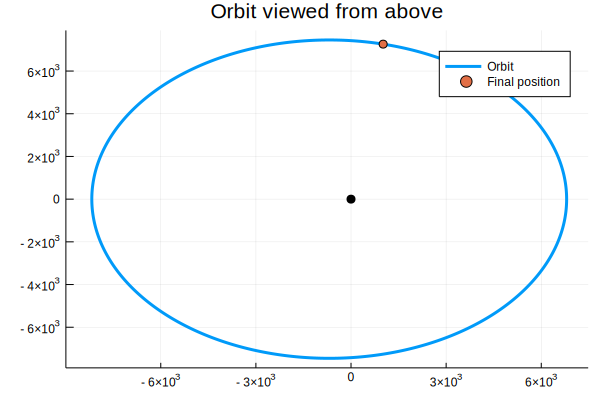

In [9]:
# units: position [km], velocity [km/2]
r0 = [6800., 0., 0.]; v0 = [0., 8., 0.];
rv0 = vcat(r0, v0);
tspan = (0., 3*86400.)
tstops = 2*86400 .+ collect(0:600:86400)

sol_kepler = kepler_solver(r0, v0)

prob_first = ODEProblem(first_order_newton_ode, rv0, tspan)
prob_second = SecondOrderODEProblem(second_order_newton_ode, v0, r0, tspan)

sol = solve(prob_first, Vern9(); abstol=1e-12, reltol=1e-12);
plot(sol, vars=(1,2), label="Orbit", title="Orbit viewed from above")
scatter!([sol[1,end]], [sol[2,end]], label="Final position")
scatter!([[0]], [[0]], label="", color=:black)

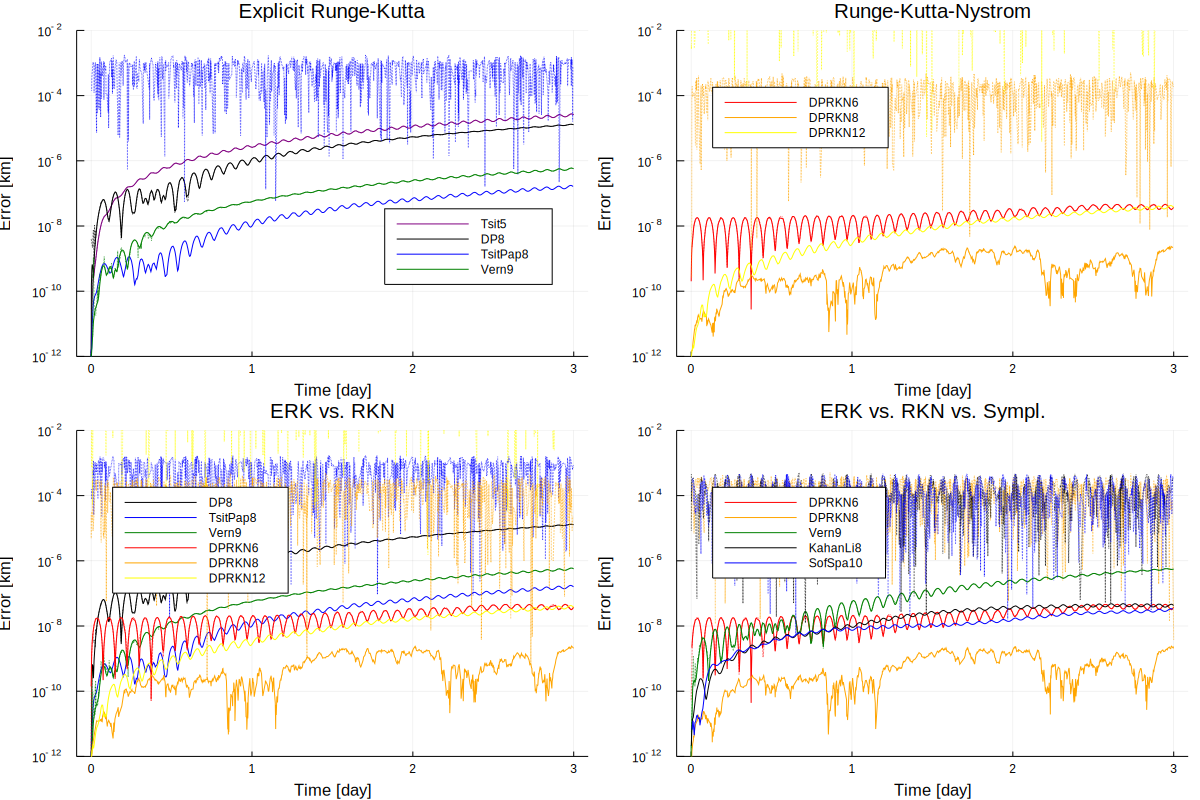

In [10]:
make_error_plots(prob_first, prob_second, sol_kepler; abstol=1e-12, reltol=1e-12, dt=60)

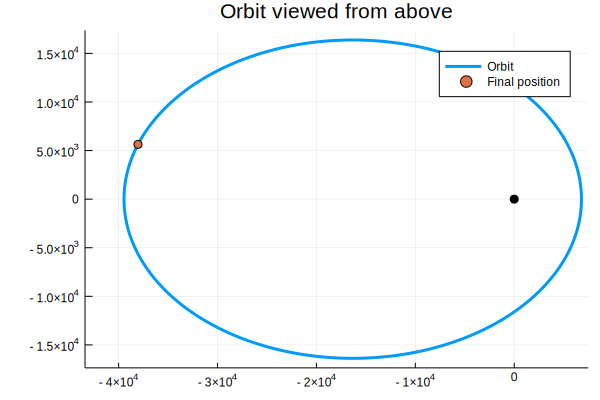

In [11]:
# units: position [km], velocity [km/2]
r0 = [6800., 0., 0.]; v0 = [0., 10., 0.];
rv0 = vcat(r0, v0);
tspan = (0., 3*86400.)
tstops = 2*86400 .+ collect(0:600:86400)

sol_kepler = kepler_solver(r0, v0)

prob_first = ODEProblem(first_order_newton_ode, rv0, tspan)
prob_second = SecondOrderODEProblem(second_order_newton_ode, v0, r0, tspan)

sol = solve(prob_first, Vern9(); abstol=1e-12, reltol=1e-12);
plot(sol, vars=(1,2), label="Orbit", title="Orbit viewed from above")
scatter!([sol[1,end]], [sol[2,end]], label="Final position")
scatter!([[0]], [[0]], label="", color=:black)

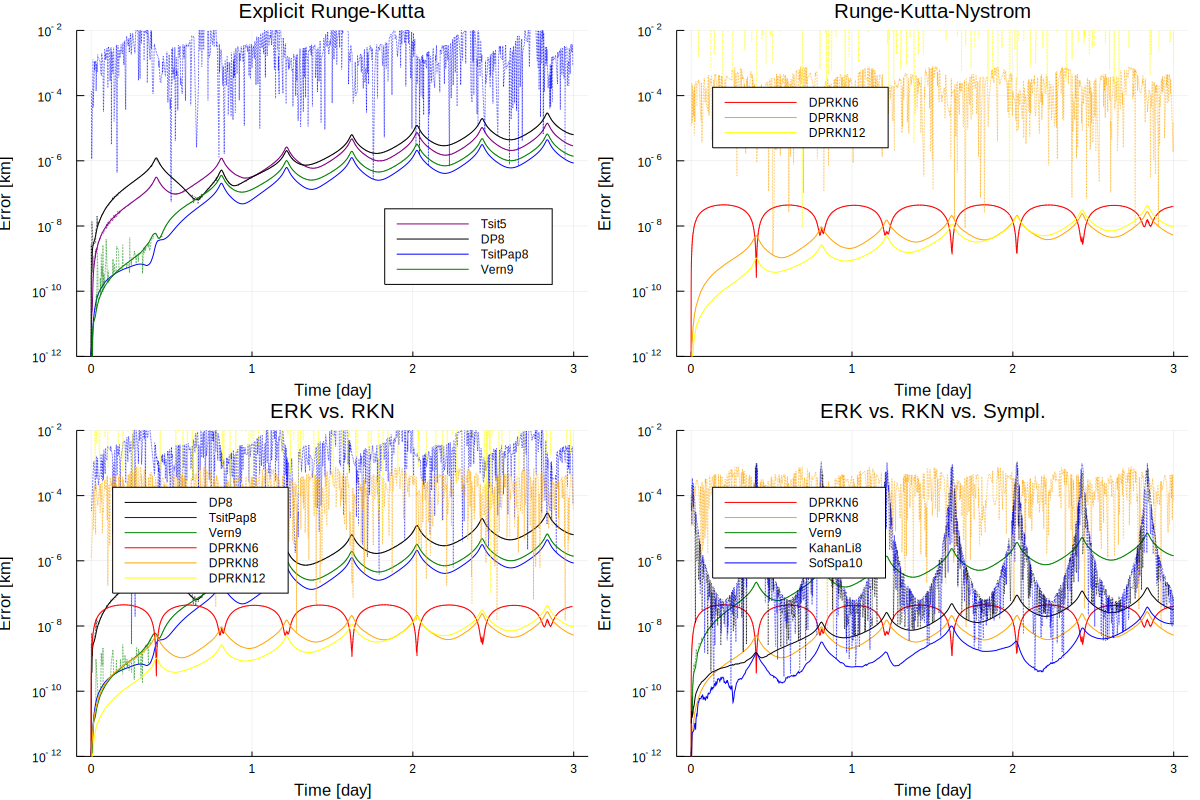

In [12]:
make_error_plots(prob_first, prob_second, sol_kepler; abstol=1e-12, reltol=1e-12, dt=60)

###  30 days propagation

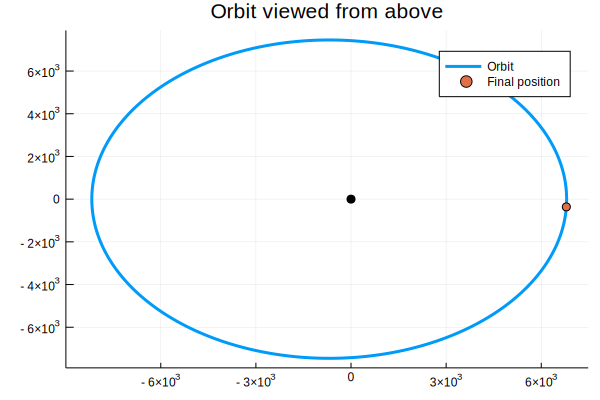

In [13]:
# units: position [km], velocity [km/2]
r0 = [6800., 0., 0.]; v0 = [0., 8., 0.];
rv0 = vcat(r0, v0);
tspan = (0., 30*86400.)
tstops = 2*86400 .+ collect(0:600:86400)

sol_kepler = kepler_solver(r0, v0)

prob_first = ODEProblem(first_order_newton_ode, rv0, tspan)
prob_second = SecondOrderODEProblem(second_order_newton_ode, v0, r0, tspan)

sol = solve(prob_first, Vern9(); abstol=1e-12, reltol=1e-12);
plot(sol, vars=(1,2), label="Orbit", title="Orbit viewed from above")
scatter!([sol[1,end]], [sol[2,end]], label="Final position")
scatter!([[0]], [[0]], label="", color=:black)

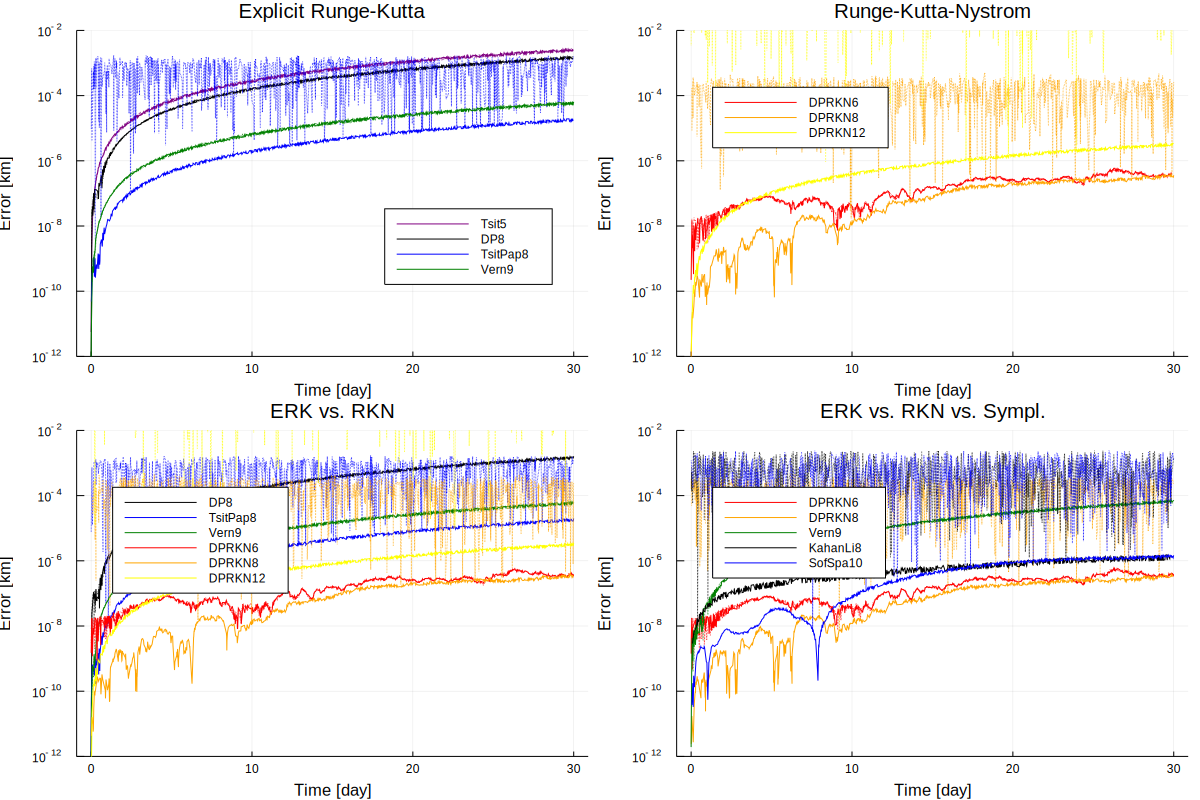

In [14]:
make_error_plots(prob_first, prob_second, sol_kepler; abstol=1e-12, reltol=1e-12, dt=90)

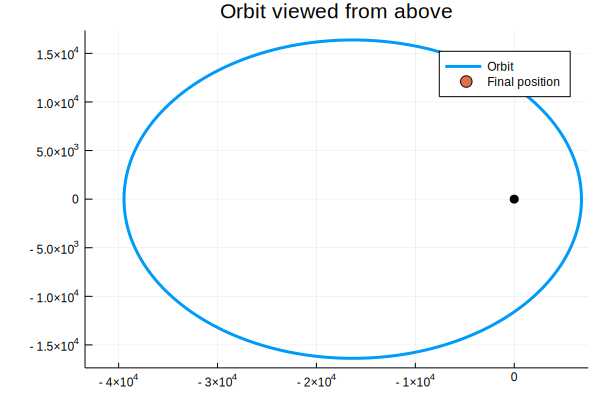

In [15]:
# units: position [km], velocity [km/2]
r0 = [6800., 0., 0.]; v0 = [0., 10., 0.];
rv0 = vcat(r0, v0);
tspan = (0., 30*86400.)
tstops = 2*86400 .+ collect(0:600:86400)

sol_kepler = kepler_solver(r0, v0)

prob_first = ODEProblem(first_order_newton_ode, rv0, tspan)
prob_second = SecondOrderODEProblem(second_order_newton_ode, v0, r0, tspan)

sol = solve(prob_first, Vern9(); abstol=1e-12, reltol=1e-12);
plot(sol, vars=(1,2), label="Orbit", title="Orbit viewed from above")
scatter!([sol[1,end]], [sol[2,end]], label="Final position")
scatter!([[0]], [[0]], label="", color=:black)

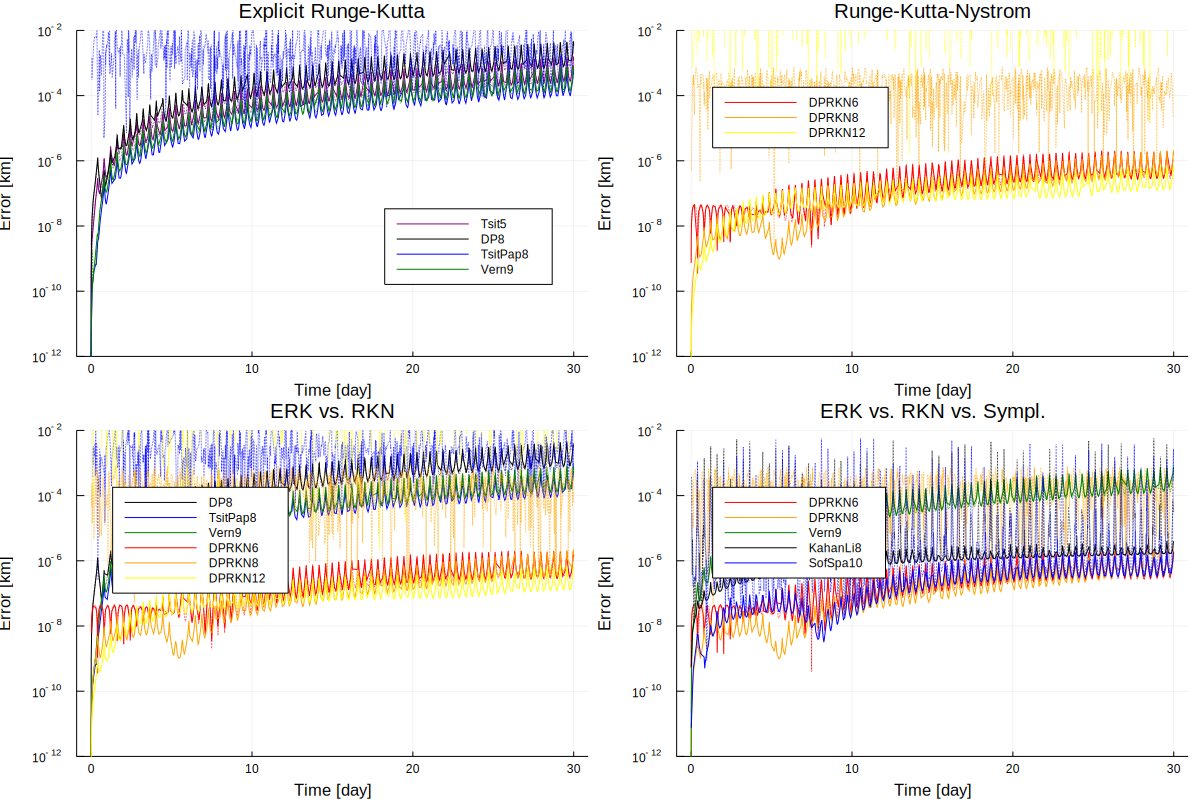

In [16]:
make_error_plots(prob_first, prob_second, sol_kepler; abstol=1e-12, reltol=1e-12, dt=90)